In [1]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import coint
import numpy as np
from scipy import signal
from sklearn.preprocessing import MinMaxScaler

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cex = pd.read_pickle("/content/drive/MyDrive/TU/cex_SHIB_USDT_2022.pkl")
dex = pd.read_pickle("/content/drive/MyDrive/TU/dex_SHIB_USDT_2022_allblocks.pkl")

In [3]:
# Resample txHash
candles = dex.resample('1T').agg({'price': [('open','first'),('high','max'), ('low','min'), ('close','last')]})
candles.columns = ['open','high','low','close']

# Forward Fill Close Price
candles['close'].ffill(inplace=True)

# Cross Fill High and Low from Close Price
candles['high'].fillna(candles['close'],inplace=True)
candles['low'].fillna(candles['close'],inplace=True)

# Starting from second row, fill the open price with the previous close price
candles.iloc[1:,0] = candles['close'].iloc[0:-1]

In [4]:
# Filtering and merging price data
merged = cex.merge(candles, left_index=True, right_index=True, suffixes=('_cex', '_dex'))
df_filt = merged[['close_cex', 'close_dex']].dropna(subset=['close_cex', 'close_dex'])
df = df_filt.rename(columns={'close_cex': 'cex_price', 'close_dex': 'dex_price'})

# Normalize the price data
scaler = MinMaxScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df[['cex_price', 'dex_price']]), columns=['cex_price', 'dex_price'], index=df.index)


In [5]:
df_norm


,cex_price,dex_price
2022-01-01 00:56:00,0.952126,0.955799
2022-01-01 00:57:00,0.953198,0.955791
2022-01-01 00:58:00,0.953912,0.956053
2022-01-01 00:59:00,0.952483,0.955890
2022-01-01 01:00:00,0.951054,0.955890
...,...,...
2022-12-31 14:27:00,0.036442,0.038802
2022-12-31 14:28:00,0.036442,0.039205
2022-12-31 14:29:00,0.036084,0.039294
2022-12-31 14:30:00,0.036084,0.039529


In [6]:
def cross_correlation(series1, series2, max_lag):
    correlation_values = []
    lag_values = []

    for lag in range(-max_lag, max_lag + 1):
        shifted_series2 = np.roll(series2, lag)
        valid_indices = abs(lag)

        correlation = np.corrcoef(series1[valid_indices:], shifted_series2[valid_indices:])[0, 1]
        correlation_values.append(correlation)
        lag_values.append(lag)

    max_correlation_index = np.argmax(correlation_values)
    max_correlation = correlation_values[max_correlation_index]
    lag = lag_values[max_correlation_index]

    return lag, max_correlation


In [7]:
def plot_cross_correlation(lag_values, correlation_values):
    plt.stem(lag_values, correlation_values)
    plt.xlabel('Lag')
    plt.ylabel('Correlation')
    plt.title('Cross Correlation Plot')
    plt.show()


In [8]:
def test_cross_correlation_with_window(series1, series2, window_size, step_size):
    num_windows = (len(series1) - window_size) // step_size + 1
    correlation_values = []
    lag_values = []

    for i in range(num_windows):
        start_index = i * step_size
        end_index = start_index + window_size
        window_series1 = series1[start_index:end_index]
        window_series2 = series2[start_index:end_index]
        lag, correlation = cross_correlation(window_series1, window_series2, max_lag=20)

        correlation_values.append(correlation)
        lag_values.append(lag)

    return lag_values, correlation_values


In [13]:
window_lags, window_correlations = test_cross_correlation_with_window(df_norm.dex_price, df_norm.cex_price, window_size=3600, step_size=1800)

In [14]:
print(window_lags)

[1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 3, 3, 2, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 2, 3, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 3, 2, 1, 1, 1, 2, 1, 4, 3, 1, 1, 1, 7, 4, 1, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 0, 0, 1, 2, 1, 1, 0, 0, 1, 3, 2, 1, 2, 1, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 5, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 2, 2, 1, 0, 0, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 0, 1, 3, 2, 0, 1, 1, 1, 2, 0, 0, 2, 2, 1, 1, 3, 3, 1, 1, 1, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 3, 5, 3, 1, 0, 0, 1, 1, 3, 2, 0, 1, 0, 0, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 0, 0, 1, 1, 2]


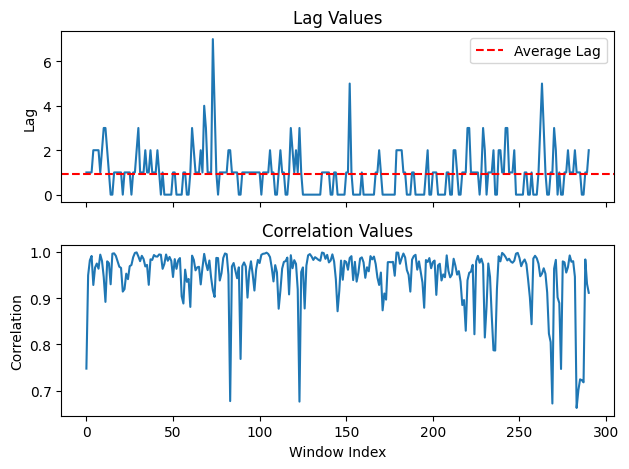

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# Plot lags
ax1.plot(range(len(window_lags)), window_lags)
ax1.axhline(y=sum(window_lags) / len(window_lags), color='red', linestyle='--', label='Average Lag')
ax1.set_ylabel('Lag')
ax1.set_title('Lag Values')
ax1.legend()

# Plot correlations
ax2.plot(range(len(window_correlations)), window_correlations)
ax2.set_xlabel('Window Index')
ax2.set_ylabel('Correlation')
ax2.set_title('Correlation Values')

plt.tight_layout()
plt.savefig('cross_correlation_shib_plot.png', dpi=300)
plt.show()

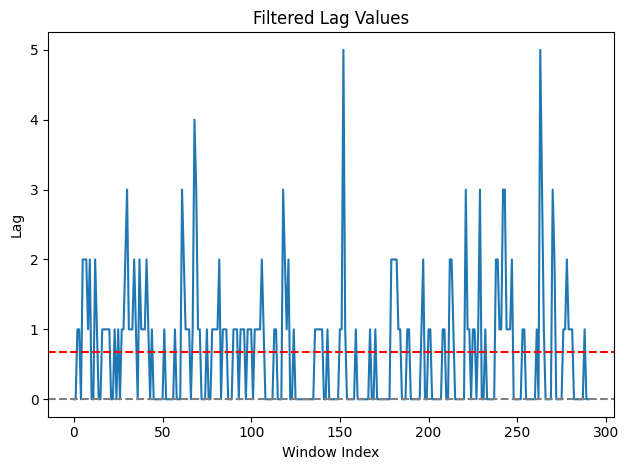

In [16]:
fig, ax = plt.subplots()

# Filter lag values based on correlation threshold
filtered_lags = [lag if correlation >= .95 else 0 for lag, correlation in zip(window_lags, window_correlations)]

# Plot filtered lag values
ax.plot(range(len(filtered_lags)), filtered_lags)
ax.axhline(y=sum(filtered_lags) / len(filtered_lags), color='red', linestyle='--', label='Average Lag')
ax.axhline(y=0, color='gray', linestyle='--')
ax.set_ylabel('Lag')
ax.set_xlabel('Window Index')
ax.set_title('Filtered Lag Values')

plt.tight_layout()
plt.savefig('cross_correlation_shib_filtered_plot.png', dpi=300)
plt.show()